In [102]:
import pandas as pd
import numpy as np

import collections

import networkx as nx

import statistics 

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [103]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G] if x in candidates]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [104]:
def candidates_at_distance(dict_distances, node, d):
    return len([dist for dist in dict_distances.get(node).values() if dist == d])

In [106]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
candidates = pd.read_pickle("./data/candidateGenesList_MMAF.p")

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)

candidates_MMAF = list(set([c for c in candidates if c in G.nodes()]))
nonCandidates_MMAF = [n for n in G.nodes() if n not in candidates_MMAF] 


print(f"Interactome size: {len(G.nodes())}, number of MMAF candidates in interactome: {len(candidates_MMAF)}")

Interactome size: 14465, number of MMAF candidates in interactome: 40


In [107]:
# find the longest distance between MMAF and non-MMAF genes
dict_distances = {}
longest_distance = 0

for source in tqdm(nonCandidates_MMAF):
    dict_tmp = {}

    for target in candidates_MMAF:
        try:
            distance = nx.shortest_path_length(G, source, target)
            dict_tmp[target] = distance

            if distance > longest_distance:
                longest_distance = distance
        except:
            continue

    dict_distances[source] = dict_tmp

print(f"Longest distance between MMAF and non-MMAF gene: {longest_distance}")

100%|██████████| 14425/14425 [00:24<00:00, 590.11it/s]

Longest distance between MMAF and non-MMAF gene: 10


### Calculate new centrality for every non-MMAF gene

In [108]:
# set alpha parameter
alpha = 0.5

In [111]:
# calculate new centrality for every non-MMAF gene
dict_scores = {}

for i in tqdm(range(len(nonCandidates_MMAF))):
    node = nonCandidates_MMAF[i]
    score = 0

    candidates_MMAF_tmp = [node] + list(set(candidates_MMAF))
    A = nx.adjacency_matrix(G, candidates_MMAF_tmp).todense()

    for j in range(len(candidates_MMAF)):
        candidate = candidates_MMAF[j]
        d = dict_distances.get(node, 0).get(candidate, 0)
        score += alpha ** d * np.linalg.matrix_power(A, d)[0][j]
    
    dict_scores[node] = score
    
dict_scores_sorted = dict(sorted(dict_scores.items(), key=lambda v: v[1], reverse=True))

100%|██████████| 14425/14425 [01:10<00:00, 205.04it/s]


In [112]:
# get more info about each node (degree, candidates at distances)
for n, score in dict_scores_sorted.items():
    dict_scores_sorted[n] = [score, 
                             G.degree(n), 
                             candidates_at_distance(dict_distances, n, 1), 
                             candidates_at_distance(dict_distances, n, 2),
                             candidates_at_distance(dict_distances, n, 3),
                             candidates_at_distance(dict_distances, n, 4)]

df = pd.DataFrame.from_dict(dict_scores_sorted, 
                            orient='index', 
                            columns=['score', 'degree', 'candidates at d=1', 'candidates at d=2', 'candidates at d=3', 'candidates at d=4'])

In [ ]:
# get gene names to ENSG
genes_df = pd.read_csv("./data/canonicalGenes.tsv", sep='\t')

df_res = df.merge(genes_df, left_index=True, right_on='ENSG')

In [126]:
# get top 20 genes
df_top = df_res.sort_values(by='score', ascending=False).head(20)
df_top

,score,degree,candidates at d=1,candidates at d=2,candidates at d=3,candidates at d=4,GENE,ENSG
1632,3.2500,81,3,4,19,12,TXLNA,ENSG00000084652
14616,1.7500,19,2,1,10,24,SEPTIN1,ENSG00000180096
17578,1.6875,45,2,4,16,17,PNMA5,ENSG00000198883
3831,1.6250,62,2,5,20,12,KRT18,ENSG00000111057
2418,1.5000,103,2,6,15,16,NINL,ENSG00000101004
2266,1.5000,50,2,1,20,12,MYH9,ENSG00000100345
16826,1.5000,52,2,4,14,19,BORCS6,ENSG00000196544
9256,1.5000,30,3,2,13,17,KIAA1328,ENSG00000150477
9237,1.4375,83,2,0,19,17,ITGB1,ENSG00000150093
3902,1.3125,78,2,0,25,13,GAPDH,ENSG00000111640


### Analyze the results

<Axes: xlabel='score', ylabel='Count'>

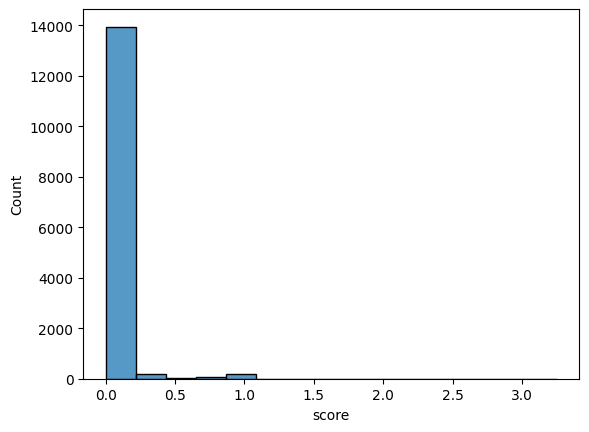

In [118]:
sns.histplot(data=df, x='score')

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Axes: ylabel='score'>

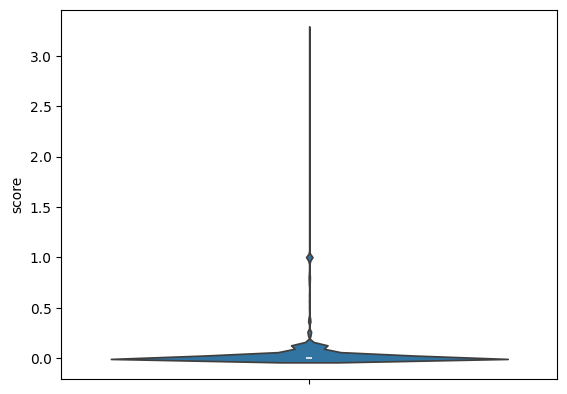

In [120]:
sns.violinplot(data=df, y='score')

### Analyze scores for new candidates from 13/02/2024

In [167]:
new_candidates = ['CLHC1', 'PHF20', 'NUSAP1', 'CDC20B', 'FAM221A', 'GALR3', 'LRRC9', 'KIF27', 'ZNF208', 'C6orf118', 'CCDC66', 'CCNA1', 'DDX43', 'FSCB', 'FHAD1', 'LRGUK', 'MYCBPAP', 'MYH7B', 'PCDHB15', 'SAMD15', 'SPACA9', 'SPATA24', 'SPATA6', 'TSSK4', 'TTLL2']
dict_new_candidates = dict([(gene, genes_df[genes_df['GENE'] == gene]['ENSG'].values[0]) for gene in new_candidates])

In [152]:
# check what percentage of new candidates is in interactome
len([nc for nc in dict_new_candidates.values() if nc in G.nodes()]) / len(dict_new_candidates.values())

0.68

In [171]:
# check scores of new candidates
df_new_candidates = df_res[df_res['ENSG'].isin(dict_new_candidates.values())]

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


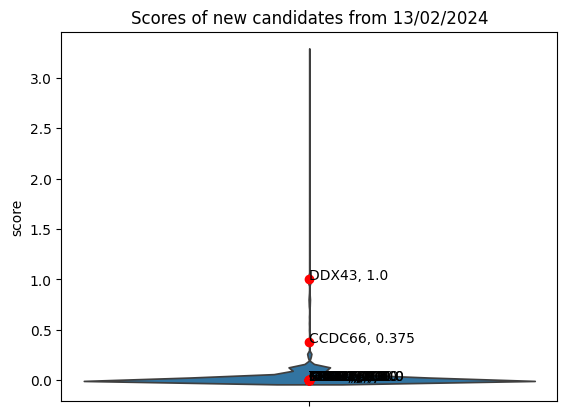

In [173]:
# plot scores of new candidates
sns.violinplot(data=df, y='score')
plt.title("Scores of new candidates from 13/02/2024")

for idx, row in df_new_candidates.iterrows():
    gene = row['GENE']
    score = row['score']
    plt.plot(score, 'or')
    plt.text(0, score, s=f"{gene}, {score}")